In [1]:
!pip install -Uqq fastbook
!pip install graphviz
# !pip install fastai --upgrade

In [2]:
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *
from fastai.vision.widgets import *

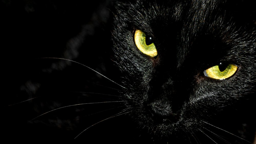

In [4]:
# skipping using azure bing api to get images in favor of duckduckgo
urls = search_images_ddg('black cats', max_images=100)
len(urls),urls[0]

download_url(urls[0], 'images/black_cat.jpg')
im = Image.open('images/black_cat.jpg')
im.thumbnail((256,256))
im

In [5]:
feline_types = 'black cat','lion','tiger','panther'
path = Path('felines')

In [6]:
import shutil

file_path = 'felines/'

try: 
    shutil.rmtree(file_path)
except OSError as e:
    print("Error: %s : %s" % (file_path, e.strerror))

In [7]:
try:
    count = 0
    if not path.exists():
        path.mkdir()
        for o in feline_types:
            count += 1
            print(count)
            dest = (path/o)
            dest.mkdir(exist_ok=True)
            results = search_images_ddg(f'{o}', max_images=150)
            # print(results)
            download_images(dest, urls=results)
except Exception as e:
    print(e)
                  

1
2
3
4


In [8]:
fns = get_image_files(path)
fns

(#717) [Path('felines/tiger/00000013.jpg'),Path('felines/tiger/00000087.jpg'),Path('felines/tiger/00000057.png'),Path('felines/tiger/00000011.jpg'),Path('felines/tiger/00000135.jpg'),Path('felines/tiger/00000054.jpg'),Path('felines/tiger/00000165.jpg'),Path('felines/tiger/00000128.jpg'),Path('felines/tiger/00000024.jpg'),Path('felines/tiger/00000006.jpg')...]

In [9]:
failed = verify_images(fns)
failed

(#8) [Path('felines/tiger/00000171.jpg'),Path('felines/tiger/00000072.jpg'),Path('felines/lion/00000085.jpg'),Path('felines/lion/00000002.png'),Path('felines/lion/00000053.jpg'),Path('felines/black cat/00000079.jpg'),Path('felines/panther/00000105.jpg'),Path('felines/panther/00000028.jpg')]

In [10]:
failed.map(Path.unlink)

(#8) [None,None,None,None,None,None,None,None]

In [11]:
felines = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=2),
    get_y=parent_label,
    item_tfms=Resize(128)
    # item_tfms=RandomResizedCrop(128, min_scale=0.3)    
)

In [12]:
dls = felines.dataloaders(path)

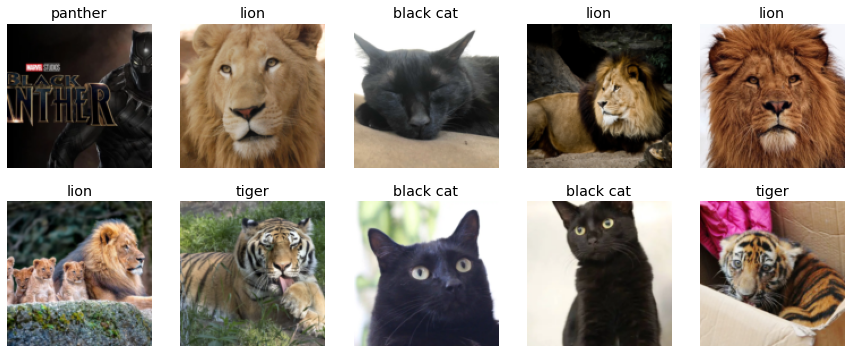

In [13]:
dls.valid.show_batch(max_n=10, nrows=2)

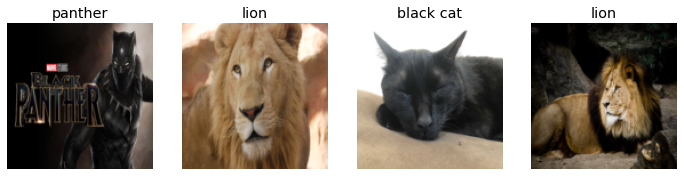

In [14]:
felines = felines.new(item_tfms=Resize(128, ResizeMethod.Squish))
dls = felines.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

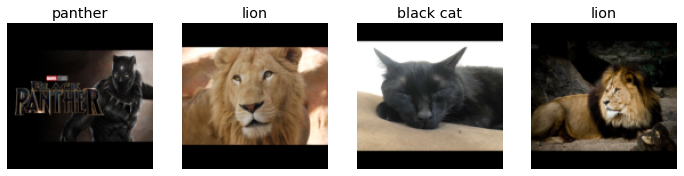

In [15]:
felines = felines.new(item_tfms=Resize(128, ResizeMethod.Pad, pad_mode='zeros'))
dls = felines.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

In [16]:
doc(DataBlock)

,Type,Default
blocks,NoneType,``
dl_type,NoneType,``
getters,NoneType,``
n_inp,NoneType,``
item_tfms,NoneType,``
batch_tfms,NoneType,``
get_items,NoneType,``
splitter,NoneType,``
get_y,NoneType,``
get_x,NoneType,``


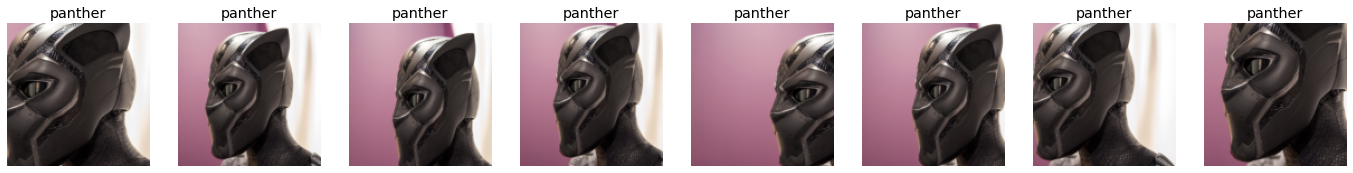

In [17]:
felines = felines.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls = felines.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

/home/th-wsl/.local/lib/python3.8/site-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


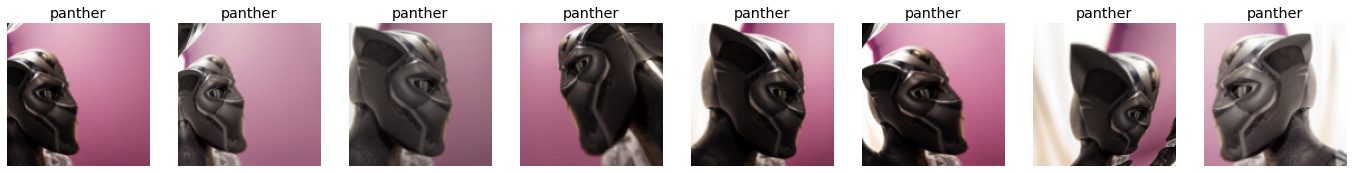

In [18]:
felines = felines.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
dls = felines.dataloaders(path)
dls.train.show_batch(max_n=8, nrows=1, unique=True)

In [19]:
felines = felines.new(
    item_tfms=RandomResizedCrop(224, min_scale=0.5),
    batch_tfms=aug_transforms())
dls=felines.dataloaders(path)

In [20]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.376130,0.077244,0.021277,00:56


epoch,train_loss,valid_loss,error_rate,time
0,0.251346,0.080329,0.021277,01:29
1,0.220814,0.064435,0.021277,01:44
2,0.176702,0.093396,0.035461,01:16
3,0.156017,0.098678,0.035461,01:44


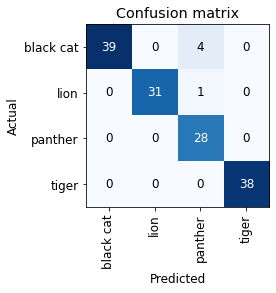

In [21]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

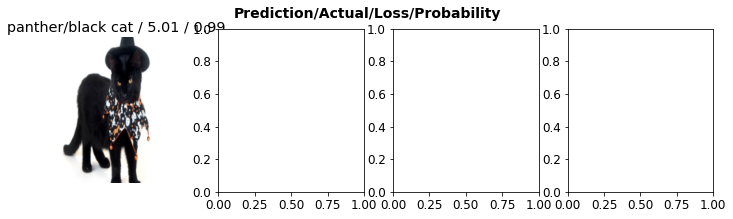

In [22]:
interp.plot_top_losses(4, nrows=1)

In [23]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [46]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink()
for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat)

In [47]:
learn.export()

In [48]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

In [49]:
learn_inf = load_learner(path/'export.pkl')

In [50]:
learn_inf.predict('images/black_cat.jpg')

('black cat',
 TensorBase(0),
 TensorBase([9.8923e-01, 1.0615e-04, 3.4829e-03, 7.1816e-03]))

In [51]:
learn_inf.dls.vocab

['black cat', 'lion', 'panther', 'tiger']

In [52]:
btn_upload = widgets.FileUpload()

In [53]:
btn_upload

FileUpload(value={}, description='Upload')

In [54]:
btn_upload = SimpleNamespace(data = ['images/black_cat.jpg'])

In [55]:
img = PILImage.create(btn_upload.data[-1])

In [56]:
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [57]:
pred,pred_idx,probs = learn_inf.predict(img)

In [58]:
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: black cat; Probability: 0.9892')

In [59]:
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

In [60]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [61]:
btn_upload = widgets.FileUpload()

In [62]:
VBox([widgets.Label('Select your feline!'), btn_upload, btn_run, out_pl, lbl_pred])

In [64]:
!pip install voila
# !jupyter serverextension enable --sys-prefix voila

# removig --sys-prefix removes a previous permissions error
# likely related to use of the system python 
# more info here https://github.com/jupyter/notebook/issues/1731
!jupyter serverextension enable voila

Enabling: voila
- Writing config: /home/th-wsl/.jupyter
    - Validating...
      voila 0.3.2 OK
